In [18]:
import matplotlib.pyplot as plt
import random
import numpy as np
from matplotlib.colors import ListedColormap
from sklearn import datasets, model_selection

In [19]:
random.seed(42)


def get_bootstrap(data, labels, N):
    n_samples = data.shape[0]
    bootstrap = []
    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]
        bootstrap.append((b_data, b_labels))
    return bootstrap


def get_subsample(len_sample):
    sample_indexes = [i for i in range(len_sample)]
    len_subsample = int(np.sqrt(len_sample))
    subsample = []
    random.shuffle(sample_indexes)
    for _ in range(len_subsample):
        subsample.append(sample_indexes.pop())
    return subsample


class Node:
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index
        self.t = t
        self.true_branch = true_branch
        self.false_branch = false_branch


class Leaf:
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()

    
    def predict(self):
        classes = {}
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        return max(classes, key=classes.get)


def gini(labels):
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
    return impurity


def quality(left_labels, right_labels, current_gini):
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)


def split(data, labels, index, t):
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
    return true_data, false_data, true_labels, false_labels


def find_best_split(data, labels):
    min_leaf = 1
    current_gini = gini(labels)
    best_quality = 0
    best_t = None
    best_index = None
    n_features = data.shape[1]
    subsample = get_subsample(n_features)
    for index in subsample:
        t_values = np.unique([row[index] for row in data])
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            current_quality = quality(true_labels, false_labels, current_gini)
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index
    return best_quality, best_t, best_index


def build_tree(data, labels):
    quality, t, index = find_best_split(data, labels)
    if quality == 0:
        return Leaf(data, labels)
    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)
    return Node(index, t, true_branch, false_branch)


def random_forest(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
    return forest


def classify_object(obj, node):
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer
    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)


def predict(data, tree):
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes


def tree_vote(forest, data):
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
    predictions_per_object = list(zip(*predictions))
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))     
    return voted_predictions

1. Сформируйте посредством sklearn.make_classification датасет из 100 объектов с двумя признаками. Обучите случайный лес из 1, 3, 10 и 50 деревьев и визуализируйте их разделяющие гиперплоскости на графиках по подобию визуализации деревьев из предыдущего урока, заменив вызов функции predict на tree_vote.

In [20]:
def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))


def plot_graphs(train_data, train_labels, test_data, test_labels, forest):
    colors = ListedColormap(['red', 'blue'])
    light_colors = ListedColormap(['lightcoral', 'lightblue'])
    fig, axes = plt.subplots(1, 2, figsize = (16, 7))
    # график обучающей выборки
    xx, yy = get_meshgrid(train_data)
    mesh_predictions = np.array(tree_vote(forest, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    axes[0].pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    axes[0].scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
    axes[0].set_title(r'Train')
    # график тестовой выборки
    axes[1].pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    axes[1].scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
    axes[1].set_title(r'Test')

In [21]:
classification_data, classification_labels = datasets.make_classification(n_samples=100, n_features=2, n_informative = 2, n_classes = 2, n_redundant=0, n_clusters_per_class=1, random_state=23)
train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, classification_labels, test_size = 0.3, random_state = 1)

1 дерево

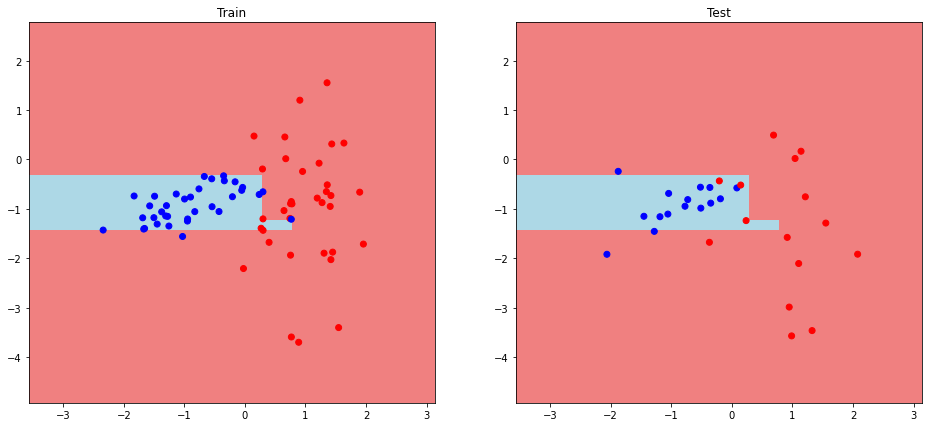

In [22]:
forest_1 = random_forest(train_data, train_labels, 1)
plot_graphs(train_data, train_labels, test_data, test_labels, forest_1)

3 дерева

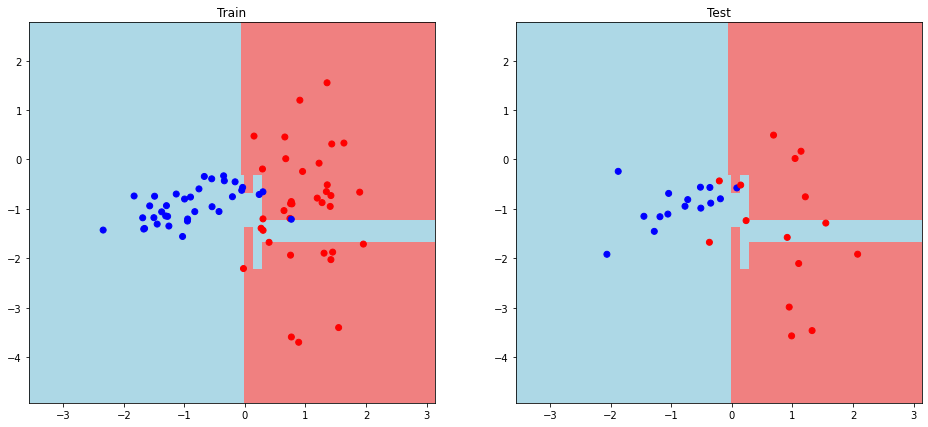

In [23]:
forest_2 = random_forest(train_data, train_labels, 3)
plot_graphs(train_data, train_labels, test_data, test_labels, forest_2)

10 деревьев

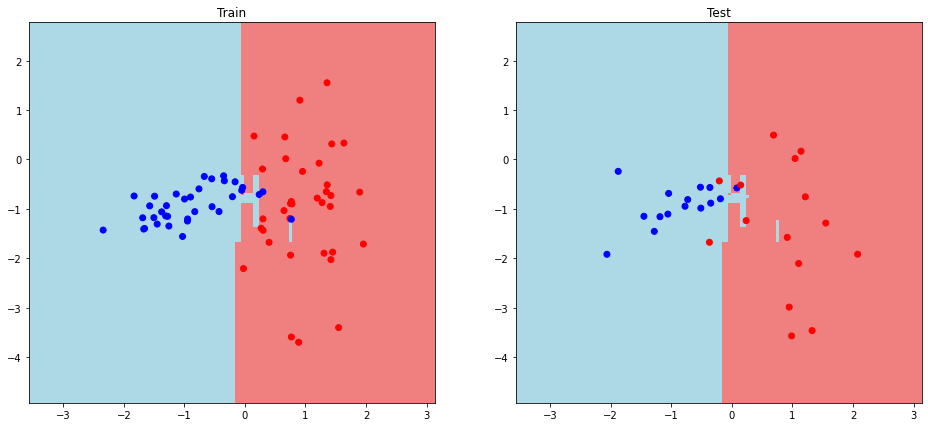

In [24]:
forest_3 = random_forest(train_data, train_labels, 10)
plot_graphs(train_data, train_labels, test_data, test_labels, forest_3)

50 деревьев

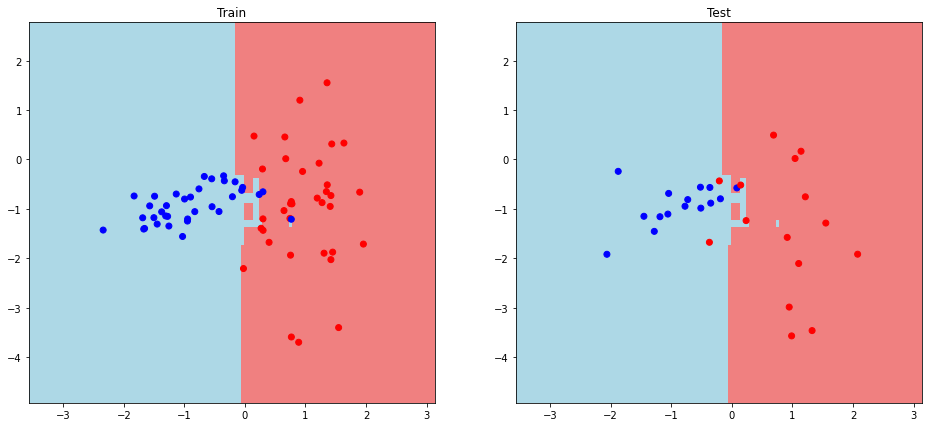

In [25]:
forest_4 = random_forest(train_data, train_labels, 50)
plot_graphs(train_data, train_labels, test_data, test_labels, forest_4)

2. Сделайте выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нём.

In [26]:
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
      if actual[i] == predicted[i]:
        correct += 1
    return correct / float(len(actual)) * 100.0

1 дерево

In [27]:
train_answers_1 = tree_vote(forest_1, train_data)
test_answers_1 = tree_vote(forest_1, test_data)
print(f'Точность на трейне: {accuracy_metric(train_labels, train_answers_1):.3f}, точность на тесте: {accuracy_metric(test_labels, test_answers_1):.3f}')

Точность на трейне: 97.143, точность на тесте: 80.000


3 дерева

In [28]:
train_answers_2 = tree_vote(forest_2, train_data)
test_answers_2 = tree_vote(forest_2, test_data)
print(f'Точность на трейне: {accuracy_metric(train_labels, train_answers_2):.3f}, точность на тесте: {accuracy_metric(test_labels, test_answers_2):.3f}')

Точность на трейне: 97.143, точность на тесте: 80.000


10 деревьев

In [29]:
train_answers_3 = tree_vote(forest_3, train_data)
test_answers_3 = tree_vote(forest_3, test_data)
print(f'Точность на трейне: {accuracy_metric(train_labels, train_answers_3):.3f}, точность на тесте: {accuracy_metric(test_labels, test_answers_3):.3f}')

Точность на трейне: 100.000, точность на тесте: 86.667


50 деревьев

In [30]:
train_answers_4 = tree_vote(forest_4, train_data)
test_answers_4 = tree_vote(forest_4, test_data)
print(f'Точность на трейне: {accuracy_metric(train_labels, train_answers_4):.3f}, точность на тесте: {accuracy_metric(test_labels, test_answers_4):.3f}')

Точность на трейне: 100.000, точность на тесте: 86.667


С увеличением количества деревьев до 10 перестают проявляться признаки переобучения, а при дальнейшем увеличением деревьев точность предсказаний перестает существенно меняться, а также получается более сложная гиперплоскость.

3. Замените в реализованном алгоритме проверку, используя отложенную выборку на Out-of-Bag.

In [31]:
def get_oob_ind(sample_indices):
    indices = np.arange(len(sample_indices))
    return indices[~np.isin(indices, sample_indices)]


def get_bootstrap_oob(data, labels, N):
    n_samples = data.shape[0]
    bootstrap_oob = []
    for i in range(N):
        sample_index = np.random.randint(0, n_samples, size=n_samples)
        b_data = data[sample_index]
        b_labels = labels[sample_index]
        oob_indices = get_oob_ind(sample_index)
        bootstrap_oob.append((b_data, b_labels, oob_indices))
    return bootstrap_oob


def predict_oob(oob_predictions, oob_indices, tree, data):
    oob_data = data[oob_indices]
    prediction = predict(oob_data, tree)
    for i in range(len(oob_indices)):
        oob_predictions[oob_indices[i], prediction[i]] += 1
    return oob_predictions


def random_forest_oob(data, labels, n_trees):
    forest = []
    oob_predictions = np.zeros((data.shape[0], len(set(labels))))
    bootstrap = get_bootstrap_oob(data, labels, n_trees)
    for b_data, b_labels, oob_indices in bootstrap:
        tree = build_tree(b_data, b_labels)
        forest.append(tree)
        oob_predictions = predict_oob(oob_predictions, oob_indices, tree, data)
        oob_score = accuracy_metric(labels, np.argmax(oob_predictions, axis=1))
    return forest, oob_score

In [32]:
oob_forest, oob_score = random_forest_oob(classification_data, classification_labels, 5)
oob_score

84.0

4. Перепишите функцию calc_gini из урока про решающие деревья так, чтобы в качестве критерия использовалась энтропия Шеннона. Переименуйте функцию в calc_entropy.

In [33]:
def calc_entropy(labels):
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    impurity = 0
    for label in classes:
        p = classes[label] / len(labels)
        if p == 0:
            pass
        else:
            impurity -= p * np.log2(p)
    return impurity